In [1]:
import pandas as pd
import numpy as np
import nflreadpy as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# load data
chap_4_file = "./data/pbp_py_chap_4_book.csv"

if os.path.isfile(chap_4_file):
    pbp_py = pd.read_csv(chap_4_file, low_memory=False)
else:
    seasons = list(range(2016, 2022 + 1))

    pbp_pl = nfl.load_pbp(seasons=seasons)  # Polars DataFrame
    pbp_py = pbp_pl.to_pandas()             # convert to pandas

    pbp_py.to_csv(chap_4_file, index=False)

In [3]:
pbp_py = pbp_py.copy()  # de-fragment

In [4]:
pbp_py_run = pbp_py.query(
    'play_type == "run" & rusher_id.notnull() &'
    + "down.notnull() & run_location.notnull()"
).reset_index()

pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

In [5]:
## set theme
sns.set_theme(style="whitegrid", palette="colorblind")

In [6]:
# Change down to be an integer
pbp_py_run.down = pbp_py_run.down.astype(str)

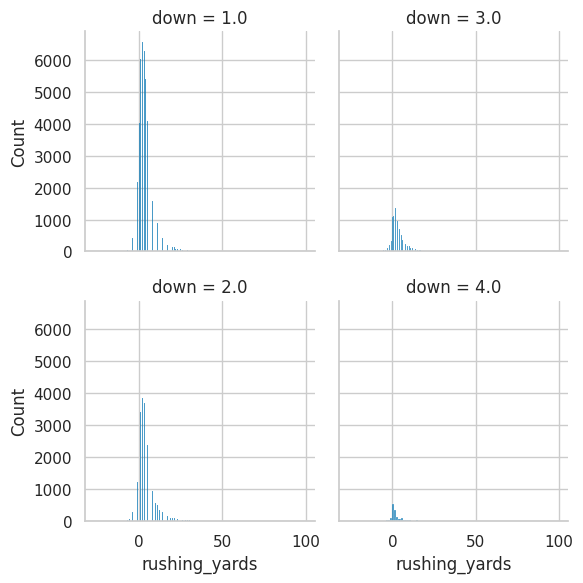

In [7]:
# Plot rushing yards by down
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.show()

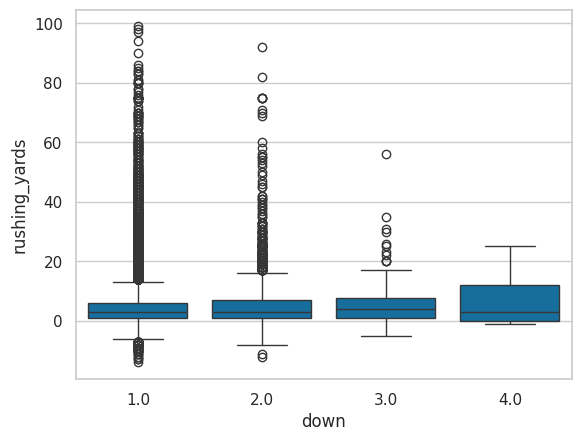

In [8]:
## Look at only plays with 10 yards to go
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"), x="down", y="rushing_yards")
plt.show()

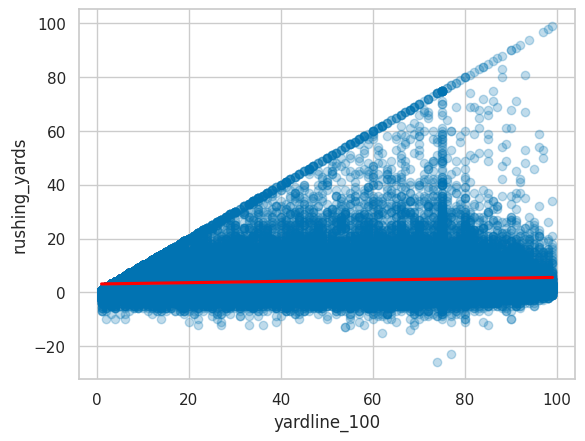

In [9]:
## scatterplot for trendline
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

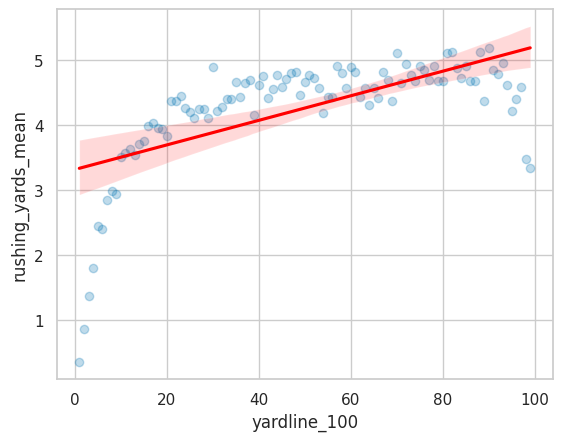

In [10]:
## Bin and plot
pbp_py_run_y100 = pbp_py_run.groupby("yardline_100").agg({"rushing_yards": ["mean"]})
pbp_py_run_y100.columns = list(map("_".join, pbp_py_run_y100.columns))
pbp_py_run_y100.reset_index(inplace=True)

sns.regplot(
    data=pbp_py_run_y100,
    x="yardline_100",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

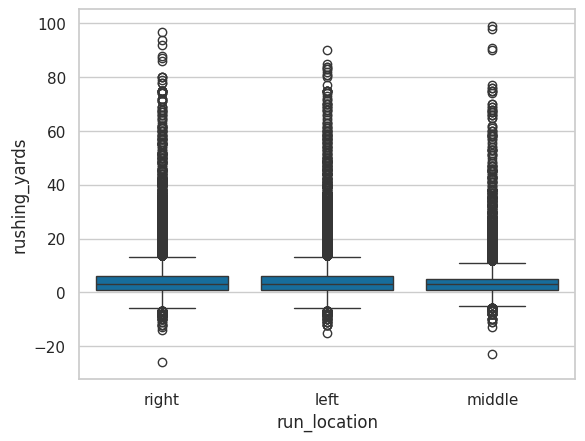

In [11]:
## Boxplot by run location
sns.boxplot(data=pbp_py_run, x="run_location", y="rushing_yards")
plt.show()

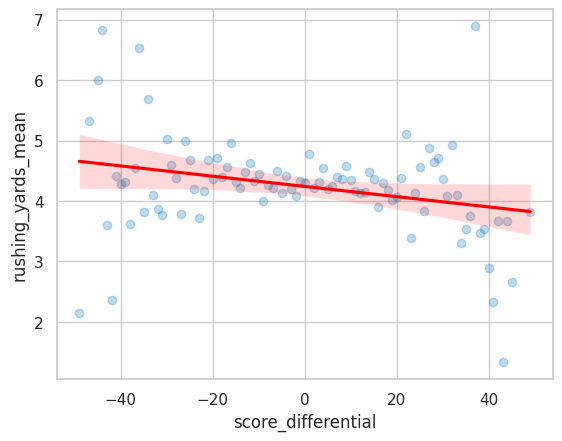

In [14]:
## Score differential
pbp_py_run_sd = pbp_py_run.groupby("score_differential").agg(
    {"rushing_yards": ["mean"]}
)
pbp_py_run_sd.columns = list(map("_".join, pbp_py_run_sd.columns))
pbp_py_run_sd.reset_index(inplace=True)

## plot score differential
sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

In [15]:
## Multiple regression Python
pbp_py_run.down = pbp_py_run.down.astype(str)
expected_yards_py = smf.ols(
    data=pbp_py_run,
    formula="rushing_yards ~ 1 + down + ydstogo + "
    + "down:ydstogo + yardline_100 + "
    + "run_location + score_differential",
).fit()
pbp_py_run["ryoe"] = expected_yards_py.resid

## Look at model outputs
print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sat, 31 Jan 2026   Prob (F-statistic):          4.53e-313
Time:                        14:00:31   Log-Likelihood:            -2.9760e+05
No. Observations:               91430   AIC:                         5.952e+05
Df Residuals:                   91418   BIC:                         5.953e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1